# Demo series: Controllers & Agents

---

## Active Inference for controlling a driven damped harmonic oscillator

Wouter Kouw, 06-08-2021

### System

This project considers a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators). Consider $y(t)$ as observed displacement, $x(t)$ as the unobserved state, $u(t)$ as the driving force and $e(t)$ as measurement noise. The continuous-time dynamics of the system are:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} \, ,
$$
constitute the physical parameters. 

The measurement noise is a Wiener process, with $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$ and $\xi$ as precision parameter. Note that nearly all Gaussian distributions in this demo use [precision](https://en.wikipedia.org/wiki/Precision_%28statistics%29) instead of variance. By convention, $\mathcal{N}$ uses a mean-covariance notation, so we invert precision parameters / matrices.

#### First-order system in generalised coordinates

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u \, .$$

In this demo, we will substitute the nonlinear combinations of parameters:

$$ \theta_1 = \frac{-k}{m} \, , \quad \theta_2 = \frac{-c}{m} \, , \quad \eta = \frac{1}{m}, .$$

With that, we cast the above system into a multi-variate first-order form:

$$ \underbrace{\begin{bmatrix} x' \\ x'' \end{bmatrix}}_{z'} = \begin{bmatrix} 0 & 1 \\ \theta_1 & \theta_2 \end{bmatrix}  \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \eta \end{bmatrix} u \, ,$$

and discretize with $z' = (z_{k+1} - z_k) / \Delta t$ giving:

$$\begin{align} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \theta_1 & \theta_2 \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \eta \end{bmatrix} u_k \\
\begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \theta_1 \Delta t & \theta_2 \Delta t + 1 \end{bmatrix}}_{A(\theta)} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \underbrace{\begin{bmatrix} 0 \\ \Delta t \eta \end{bmatrix}}_{B(\eta)} u_k \, .
\end{align}$$

This produces a compact state-space model formulation:

$$\begin{align} 
z_{k+1} =&\ A(\theta) z_k + B(\eta) u_k \\
y_k =&\ c^{\top}x_k + e_k \, ,
\end{align}$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}^{\top}$ is a masking vector.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate();

  Activating environment at `C:\Users\kouww\Research\actinf-oscillator\Project.toml`


In [2]:
using Revise
using Plots
pyplot();

In [3]:
# Sampling step size
Δt = 0.1

# Physical parameters
m = 2.0
c = 0.4
k = 0.4

# Measurement noise precision
ξ_true = Inf

# Pack parameters
phys_params = (m, c, k, ξ_true);

In [4]:
# Interesting variable substitutions
ζ = c/(2*sqrt(m*k))
ω0 = sqrt(k/m)
ω1 = ω0*sqrt(1 - ζ^2)

# Report damping ratio
println("Damping ratio ζ = "*string(ζ))

# Report undamped angular frequency
println("Undamped angular frequency ω_0 = "*string(ω0))

# Report underdamped angular frequency
println("Underdamped angular frequency ω_1 = "*string(ω1))

Damping ratio ζ = 0.223606797749979
Undamped angular frequency ω_0 = 0.4472135954999579
Underdamped angular frequency ω_1 = 0.43588989435406733


In [5]:
function sim_sys(input, z_kmin1, params)
   "Simulate dynamic system"
    
    # Unpack parameters
    θ, η, ξ = params
    
    # State transition
    z_k = (S + s*θ')*z_kmin1 + s*η*input
    
    # Generate observation
    y_k = [1, 0]'*z_k + sqrt(inv(ξ))*randn(1,)[1]
    
    return y_k, z_k    
end;

In [6]:
# Utility matrices
S = [1. Δt; 0. 1.]
s = [0., Δt]

# State transition coefficients
θ1 = -k/m
θ2 = -c/m
θ_true = [θ1, θ2]

# Control coefficient
η_true = 1/m

# Pack substituted variables
subs_params = (θ_true, η_true, ξ_true)

([-0.2, -0.2], 0.5, Inf)

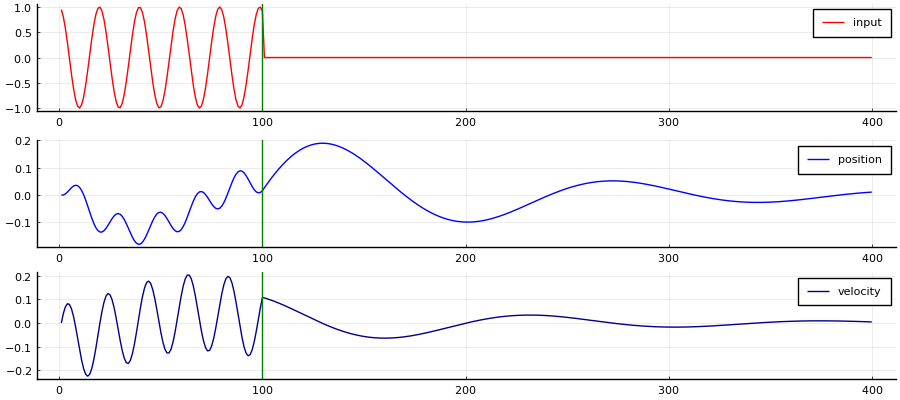

In [7]:
# Time 
T = 400
stop = T-300

# Input signal
input = [cos.((1:stop)./ π); zeros(length(stop+1:T),)]

# Preallocate arrays
states = zeros(T,2)
output = zeros(T,)

for k = 2:T
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
end

p101 = plot(1:T, input, linewidth=1, color="red", label="input", size=(900,300))
vline!([stop], color="green", label="")
p102 = plot(1:T, states[:,1], linewidth=1, color="blue", label="position", size=(900,300))
vline!([stop], color="green", label="")
p103 = plot(1:T, states[:,2], linewidth=1, color="darkblue", label="velocity", size=(900,300))
vline!([stop], color="green", label="")
p100 = plot(p101, p102, p103, layout=(3,1), size=(900,400))

In [8]:
savefig(p100, "figures/example-input-output_seq1.png")

## Model: Adaptive filter in generalised coordinates

In practice, a system is usually affected by external circumstances. We include unknown effects by adding a zero-mean Gaussian noise vector $v_k$:

$$v_k \sim \mathcal{N}\big(0, W(\tau)^{-1} \big) \, , \quad \text{with} \quad W(\tau)^{-1} = \tau \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{\Delta t^2}{2} \\ \frac{\Delta t^2}{2} & \Delta t \end{bmatrix}^{-1} \, ,
$$

where $W$ represents the precision matrix, consisting of a single precision parameter $\tau$ scaling a structured noise precision matrix.

### Likelihood

Integrating out $v_k$ and $e_k$ lets us formulate the dynamics as a Bayesian state-space model:

$$\begin{align}
z_k \sim&\ \mathcal{N}(A(\theta) z_{k-1} + B(\eta) u_k , W(\tau)^{-1}) \\
y_k \sim&\ \mathcal{N}(c^{\top} z_k, \xi^{-1}) \, .
\end{align}$$

### Priors

We choose Gaussian priors for the unknown coefficients and Gamma priors for the unknown noise precisions:

$$\begin{align}
p(\theta) = \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\tau)= \Gamma(a^{0}_\tau, b^{0}_\tau) \, , \quad
p(\xi)= \Gamma(a^{0}_\xi, b^{0}_\xi) \, .
\end{align}$$

We also need a prior distribution for the initial state: $ p(z_0) = \mathcal{N}(0, V_{z_0})$.


### Posteriors

We can apply the Bayesian filtering equations to obtain recursive posterior estimates:

$$\begin{align}\label{eq:filtering}
    \underbrace{p(z_k | x_{1:t})}_{\text{state posterior}} &= \frac{\overbrace{p(x_t | z_t)}^{\text{likelihood}}}{\underbrace{p(x_t | x_{1:t-1})}_{\text{evidence}} }  \overbrace{\iint \underbrace{p(z_t| z_{t-1},u_{t})}_{\text{state transition}} \underbrace{q(u_t)}_{\substack{\text{control} \\ \text{signal}}} \underbrace{p(z_{t-1} | x_{1:t-1})}_{\text{state prior}} \ \mathrm{d} z_{t-1} \mathrm{d} u_t}^{\text{prior predictive $p(z_t | x_{1:t-1})$}} \, ,
\end{align}$$


## Variational Bayesian inference

### Recognition model

The recognition model will follow the generative model:

$$\begin{align}
q(\theta) = \mathcal{N}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \mathcal{N}(m_{\eta}, v_{\eta}) \ , \quad  
q(\tau)= \Gamma(a_\tau, b_\tau) \, , \quad
q(\xi)= \Gamma(a_\xi, b_\xi) \, .
\end{align}$$

For the states, we have

### Free Energy function



#### Computing expectations

We need to isolate the unknown variables as separate scalar or vector variables, which can be done by splitting the equation as follows:

$$ A(\theta) = \Big(\underbrace{\begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}}_{S} + \underbrace{\begin{bmatrix} 0 \\ \Delta t \end{bmatrix}}_{s} \begin{bmatrix} \theta_1 & \theta_2 \end{bmatrix} \Big) \, , \quad B(\eta) = \underbrace{\begin{bmatrix} 0 \\ \Delta t \end{bmatrix}}_{s} \eta \, ,$$



In [9]:
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Optim
using ForneyLab

In [10]:
using GFX

┌ Info: Precompiling GFX [65bb6014-af4f-4359-bfe9-dc7ee7256e7a]
└ @ Base loading.jl:1317


In [11]:
include("util.jl");

In [12]:
graph1 = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))

# Noise precisions
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV x ~ GaussianMeanPrecision(placeholder(:m_x, dims=(2,)), placeholder(:w_x, dims=(2, 2)), id=:x_k)

# Autoregressive state transition
@RV z ~ GeneralisedFilterX(θ, x, η, placeholder(:u), τ, id=:z_k)

# Likelihood
@RV y ~ GaussianMeanPrecision(dot([1. , 0.], z), ξ, id=:y_k)
placeholder(y, :y);

# Specify recognition model
q = PosteriorFactorization(z, x, θ, η, τ, ξ, ids=[:z, :x, :θ, :η, :τ, :ξ])

# Specify and compile message passing algorithm
algo = messagePassingAlgorithm([z, x, θ, η, τ, ξ], q)
eval(Meta.parse(algorithmSourceCode(algo)));

### Experiment 1: Online system identification from known inputs

In [13]:
# Time horizon
T = 400
stop = T-200

# Design input signal
input = [cos.((1:stop)./ (6*π)); zeros(length(stop+1:T),)]
# input = [0; 0; 1; zeros(T-3,)];

In [14]:
using GFX

In [15]:
# Preallocation
states = zeros(T,2)
output = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.01 .*eye(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.01 .*eye(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.01 .*eye(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=rand(1,)[1], w=.01)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1e-1, b=1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e3, b=1e-2)

# Number of variational updates
num_iterations = 4

# Track estimated states
est_states = (zeros(T,2), zeros(T,2,2))
est_coeffs = (zeros(T,2), zeros(T,2,2))

@showprogress for k = 2:T
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => output[k],
                       :u => input[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)        
        
        # Update noise precisions
#         stepτ!(constraints, marginals)
        stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z])
    est_states[2][k,:,:] = inv(pc(marginals[:z]))
    est_coeffs[1][k,:] = mn(marginals[:θ])
    est_coeffs[2][k,:,:] = inv(pc(marginals[:θ]))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


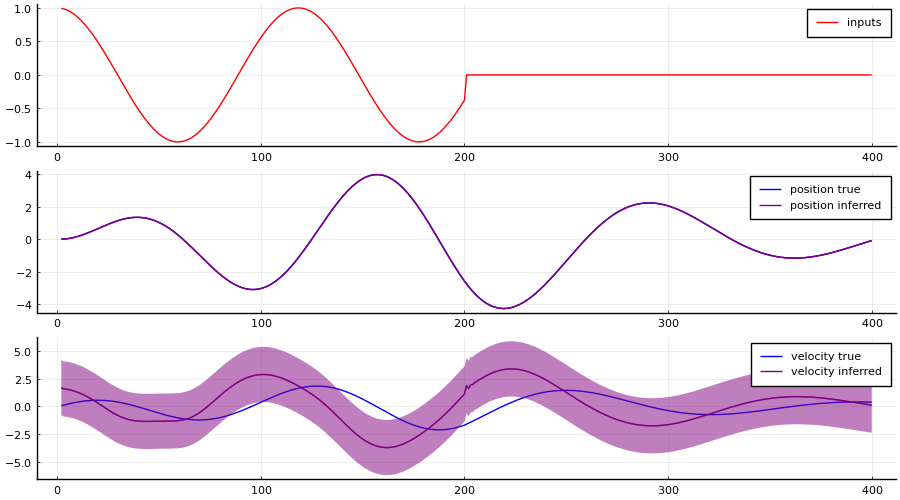

In [16]:
p201 = plot(2:T, input[2:T], color="red", label="inputs")
p202 = plot(2:T, states[2:T,1], markersize=2, color="blue", label="position true")
plot!(2:T, est_states[1][2:T,1], color="purple", label="position inferred")
plot!(2:T, est_states[1][2:T,1], ribbon=[est_states[2][2:T,1,1], est_states[2][2:T,1,1]], alpha=0.5, color="purple", label="")
p203 = plot(2:T, states[2:T,2], markersize=2, color="blue", label="velocity true")
plot!(2:T, est_states[1][2:T,2], color="purple", label="velocity inferred")
plot!(2:T, est_states[1][2:T,2], ribbon=[est_states[2][2:T,2,2], est_states[2][2:T,2,2]], alpha=0.5, color="purple", label="")
plot(p201, p202, p203, layout=(3,1), size=(900,500))

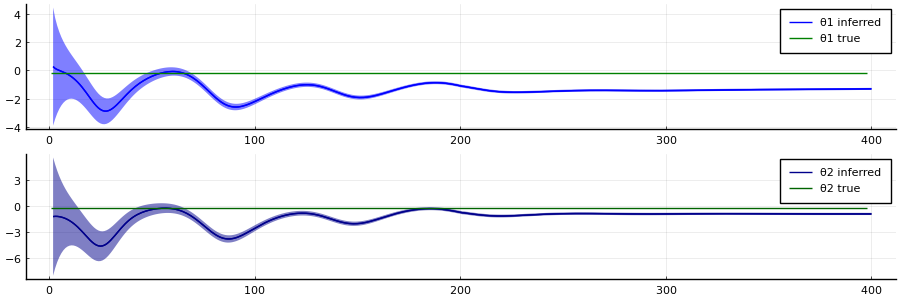

In [17]:
p1 = plot(2:T, est_coeffs[1][2:T,1], color="blue", label="θ1 inferred")
plot!(2:T, est_coeffs[1][2:T,1], ribbon=[sqrt.(est_coeffs[2][2:T,1,1]), sqrt.(est_coeffs[2][2:T,1,1])], color="blue", label="")
plot!(θ_true[1]*ones(T-2,), label="θ1 true", color="green")
p2 = plot(2:T, est_coeffs[1][2:T,2], color="darkblue", label="θ2 inferred")
plot!(2:T, est_coeffs[1][2:T,2], ribbon=[sqrt.(est_coeffs[2][2:T,2,2]), sqrt.(est_coeffs[2][2:T,2,2])], color="darkblue", label="")
plot!(θ_true[2]*ones(T-2,), label="θ2 true", color="darkgreen")
plot(p1,p2, layout=(2,1), size=(900,300))

#### Validate identified system

We validate the identified system by computing simulation error on the validation set.

In [18]:
# Time horizon
T_val = 1000

# Input signal
input_val = cos.((1:T_val)./ (6*π))
# inputs_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val];

In [19]:
# Preallocate arrays
states_val = zeros(T_val,2)
output_val = zeros(T_val,)

# Convenience variables
EA = (S + s*mn(marginals[:θ])')
EB = s*mn(marginals[:η])

# Preallocate prediction arrays
preds = (zeros(T_val,2), zeros(T_val,2,2))

@showprogress for k = 2:T_val
    
    # Simulate forward
    output_val[k], states_val[k,:] = sim_sys(input_val[k], states_val[k-1,:], subs_params)
    
    # Posterior predictive
    preds[1][k,:] = EA*preds[1][k-1,:] + EB*input_val[k]
    preds[2][k,:,:] = EA'*preds[2][k-1,:,:]*EA + inv(mn(marginals[:τ]))*noisecov(Δt, dims=2)

end

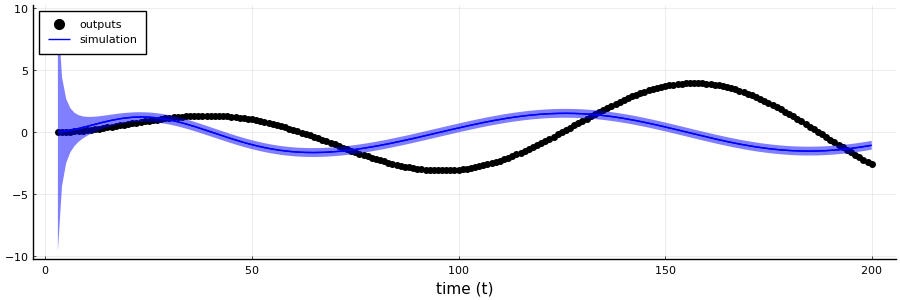

In [20]:
zoom = 3:min(200,T_val)

# Plot predictions
p23 = scatter(zoom, output_val[zoom], label="outputs", xlabel="time (t)", color="black", size=(900,300), legend=:topleft)
# plot!(zoom, inputs_val[zoom], label="inputs", color="red")
plot!(zoom, preds[1][zoom,1], label="simulation", color="blue")
plot!(zoom, preds[1][zoom], ribbon=[sqrt.(inv.(preds[2][zoom])), sqrt.(inv.(preds[2][zoom]))], label="", color="blue")

In [21]:
Plots.savefig(p23, "figures/simulations.png")

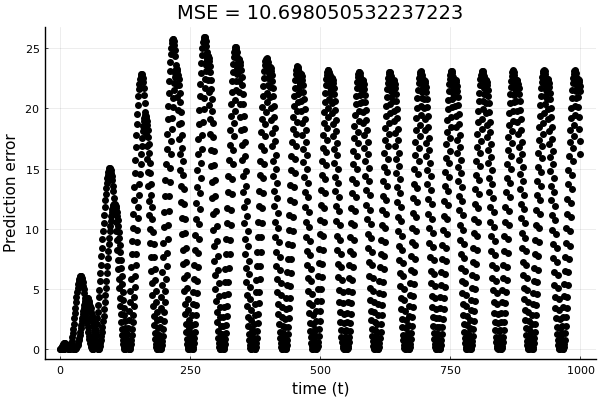

In [22]:
# Compute prediction error
sq_pred_error = (preds[1] .- output_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))

In [23]:
Plots.savefig(p24, "figures/sim-errors.png")

### Experiment 2: Online system identification with agent-regulated inputs

In [24]:
function EFE_k(action, prior_state, goal_state, model_params)

    # Unpack model parameters
    θ, η, τ, ξ = model_params

    # Process noise
    Σ_z = inv(τ) *[1. 0.; 0. 0.]

    # Helper matrices
    S = [0. 0.; 1. 0.]
    s = [1.; 0.]

    # Unpack prior state     
    μ_kmin = prior_state[1]
    Σ_kmin = prior_state[2]

    # Predicted observation
    y_hat = θ'*μ_kmin + η*action[1]
    
    # Covariance matrix
    Σ_k = Σ_kmin + Σ_z
    Σ_11 = Σ_k
    Σ_21 = s'*Σ_k
    Σ_12 = Σ_k*s
    Σ_22 = s'*Σ_k*s .+ inv(ξ)

    # Calculate conditional entropy
    Σ_cond = Σ_22 - Σ_21 * inv(Σ_11) * Σ_12
    ambiguity = 0.5(log2π + log(Σ_cond[1]) + 1)

    # Risk as KL between marginal and goal prior
    risk = KLDivergence(y_hat, Σ_22[1], goal_state[1], goal_state[2])

    # Update loss.
    return risk + ambiguity
end;

In [25]:
# Time horizon
T = 300
    
# Goal state (mean and std dev)
goal_state = (.8, 1e-4)

# Number of variational updates
num_iterations = 4

# Preallocation
input = zeros(T,)
states = zeros(T,2)
output = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.1*eye(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.1*eye(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_true, w=.1*eye(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=η_true, w=.1)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e2, b=1e-2)

# Track estimated states
est_states = (zeros(T,2), zeros(T,2,2))

@showprogress for k = 2:T
    
    "Find control"

    # Pack parameters estimated by model
#     model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:τ]), mn(marginals[:ξ]))
    model_params = (θ_true, η_true, Inf, ξ_true)

    # State prior variable
#     prior_state = (mn(marginals[:z]), inv(pc(marginals[:z])))
    prior_state = (states[k-1,:], 1e8 *eye(2))

    # Objective function
    G(u_k) = EFE_k(u_k, prior_state, goal_state, model_params)

    # Miminimize EFE
#     results = optimize(G, -1, 1, rand(1,), Fminbox(LBFGS()), Optim.Options(iterations=100); autodiff=:forward)
    results = optimize(G, rand(1,), LBFGS(), Optim.Options(iterations=100); autodiff=:forward)

    # Select first action in policy
    input[k] = Optim.minimizer(results)[1]
    
    "Execute control"
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => output[k],
                       :u => input[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
#         stepη!(constraints, marginals)
        stepθ!(constraints, marginals)
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update noise precisions
#         stepτ!(constraints, marginals)
#         stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z])
    est_states[2][k,:,:] = inv(pc(marginals[:z]))
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


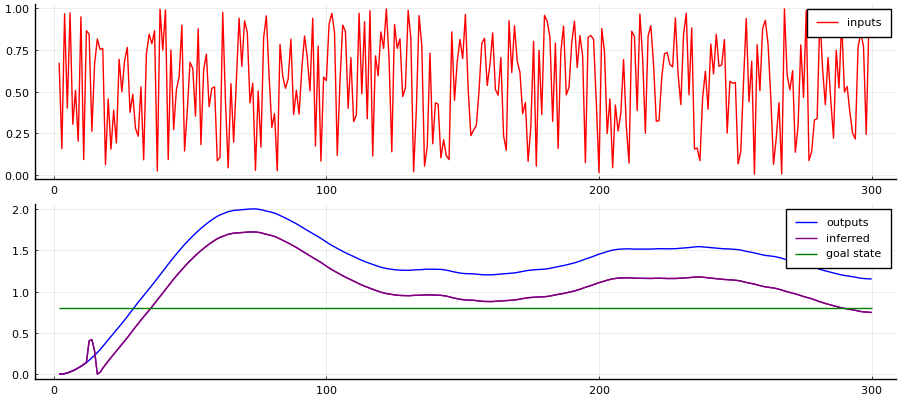

In [26]:
p1 = plot(2:T, input[2:T], color="red", label="inputs")
p2 = plot(2:T, output[2:T], color="blue", label="outputs")
plot!(2:T, est_states[1][2:T], color="purple", label="inferred")
plot!(2:T, est_states[1][2:T], ribbon=[est_states[2][2:T], est_states[2][2:T]], color="purple", label="")
plot!(2:T, goal_state[1]*ones(T-2,), color="green", label="goal state")
plot(p1, p2, layout=(2,1), size=(900,400))

#### Validation

In [27]:
# Time horizon
T_val = 1000

# Input signal
inputs_val = cos.(range(1, stop=T_val)*π/6);
# inputs_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val];

In [28]:
# Preallocate arrays
states_val = zeros(T_val,2)
output_val = zeros(T_val,)

# Convenience variables
EA = (S + s*mn(marginals[:θ])')
EB = s*mn(marginals[:η])

# Preallocate prediction arrays
preds = (zeros(T_val,2), zeros(T_val,2,2))

@showprogress for k = 2:T_val
    
    # Simulate forward
    output_val[k], states_val[k,:] = sim_sys(input_val[k], states_val[k-1,:], subs_params)
    
    # Posterior predictive
    preds[1][k,:] = EA*preds[1][k-1,:] + EB*input_val[k]
    preds[2][k,:,:] = EA'*preds[2][k-1,:,:]*EA + inv(mn(marginals[:τ]))*noisecov(Δt, dims=2)

end

In [29]:
zoom = 2:T_val

# Plot predictions
p23 = plot(zoom, output_val[zoom], label="outputs", xlabel="time (t)", color="black", size=(900,300))
# plot!(zoom, inputs_val[zoom], label="inputs", color="red")
plot!(zoom, preds[1][zoom], label="simulation", color="blue")
# plot!(zoom, preds[1][zoom], ribbon=[sqrt.(inv.(preds[2][zoom])), sqrt.(inv.(preds[2][zoom]))], label="", color="blue")

InexactError: InexactError: trunc(Int64, -Inf)

In [30]:
# Compute prediction error
sq_pred_error = (preds[1] .- outputs_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))

LoadError: UndefVarError: outputs_val not defined